# Detecting Expertise in Reading Behavior with PoTeC

This notebook analyzes data from the **PoTeC corpus** (*Jakobi, Kern, Reich, Haller & Jäger, 2022*), a German naturalistic eye-tracking-while-reading dataset. The study followed a **2 × 2 × 2 factorial design**, where experts and non-experts in physics and biology read 12 short textbook passages from both disciplines.  

Our main research question is:  
**Can we detect reader expertise from basic eye-tracking measures?**

To address this, we will compare experts and non-experts on key measures of reading behavior, such as:  
- First fixation duration (early lexical processing)  
- Total fixation time (depth of processing)  
- Number of skipped words (efficiency/familiarity)  

We will explore two complementary approaches:  
1. **Scanpath analysis** – using Scanpath Similarity (ScaSim), multidimensional scaling, and clustering to uncover expertise-related reading patterns.  
2. **Classification models** – training predictive models (e.g., logistic regression, SVM) to determine whether expertise can be inferred from eye-tracking features.  

The notebook is structured as follows:  
1. **Data loading & preprocessing**  
2. **Exploratory analysis of basic measures**  
3. **Scanpath-based similarity and clustering**  
4. **Classification approach**  
5. **Discussion of findings**  


## 1. Setup: Import Libraries and Load Data

In this step, we import the required Python libraries and functions needed to read in the original PoTeC dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy
import statsmodels.formula.api as smf

In [2]:
from scipy.stats import zscore,ttest_ind

In [3]:
def read_data(file_path):
    """
    Reads fixation data from a CSV file and returns a pandas DataFrame.
    """
    all_data = []
    files_tsv = [f for f in os.listdir(file_path) if f.endswith('.tsv')]
    print("Found TSV files:", len(files_tsv))
    for file in files_tsv:
        #german text includes the word "null", so we need to escape its intepretations as nan
        df = pd.read_csv(os.path.join(file_path, file), sep='\t',keep_default_na=False, na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan',
                       '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NaN', 'None', 'n/a',
                       'nan', ''])
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


In [4]:
# read scanpath since it contains data from both reading_measurements and fixation
scanpath_df = read_data('scanpaths_merged')

Found TSV files: 900


In [5]:
# check how data looks
scanpath_df.head()

,fixation_index,text_domain,trial,acc_bq_1,acc_bq_2,acc_bq_3,acc_tq_1,acc_tq_2,acc_tq_3,fixation_duration,...,TRC_out,TRC_in,LP,SL_in,SL_out,mean_acc_tq,mean_acc_bq,gender_numeric,age,discipline_level_of_studies_numeric
0,1,biology,2,0.0,0.0,1.0,1.0,1.0,0.0,281,...,0,1,2,2,1,0.333333,0.666667,1.0,26.0,3
1,2,biology,2,0.0,0.0,1.0,1.0,1.0,0.0,283,...,1,2,7,1,2,0.333333,0.666667,1.0,26.0,3
2,3,biology,2,0.0,0.0,1.0,1.0,1.0,0.0,394,...,0,1,1,2,1,0.333333,0.666667,1.0,26.0,3
3,4,biology,2,0.0,0.0,1.0,1.0,1.0,0.0,254,...,0,1,1,2,1,0.333333,0.666667,1.0,26.0,3
4,5,biology,2,0.0,0.0,1.0,1.0,1.0,0.0,340,...,0,1,1,2,1,0.333333,0.666667,1.0,26.0,3


In [6]:
print(scanpath_df.columns.tolist())

['fixation_index', 'text_domain', 'trial', 'acc_bq_1', 'acc_bq_2', 'acc_bq_3', 'acc_tq_1', 'acc_tq_2', 'acc_tq_3', 'fixation_duration', 'next_saccade_duration', 'previous_saccade_duration', 'version', 'line', 'aoi', 'char_index_in_line', 'original_fixation_index', 'is_fixation_adjusted', 'reader_id', 'text_id', 'word_index_in_text', 'sent_index_in_text', 'char_index_in_text', 'word', 'character', 'text_id_numeric', 'text_domain_numeric', 'reader_discipline_numeric', 'level_of_studies_numeric', 'expert_reading_label_numeric', 'expert_reading_label', 'word_with_punct', 'word_index_in_sent', 'word_length', 'STTS_punctuation_before', 'STTS_punctuation_after', 'is_in_quote', 'is_in_parentheses', 'is_clause_beginning', 'is_sent_beginning', 'is_clause_end', 'is_sent_end', 'is_abbreviation', 'is_expert_technical_term', 'is_general_technical_term', 'contains_symbol', 'contains_hyphen', 'contains_abbreviation', 'STTS_PoS_tag', 'type', 'type_length_chars', 'PoS_tag', 'lemma', 'lemma_length_chars'

In [7]:
# select columns that are needed for explanatory analysis
columns_needed = [
    "reader_id", "expert_reading_label", "reader_discipline_numeric",
    "text_id", "text_domain", "trial",
    "FFD", "RRT", "FPRT", "TFT",
    "fixation_duration", "Fix",
    "word", "word_index_in_text", "word_index_in_sent", "sent_index_in_text",
    "word_length"
]

# create a new DataFrame with the selected columns
scanpath_analysis_df = scanpath_df[columns_needed].copy()

## 2. Exploratory Analysis

In this section, we perform basic exploratory checks and visualizations to understand the PoTeC dataset and identify potential differences between experts and non-experts.

### 2.1 Basic Data Checks
- Number of participants and texts
- Distribution of expertise groups (balanced or not)
- Missing values
- Extreme fixation durations (filter using z-scores)

In [8]:
# check number of participants in scanpath_analysis_df
print(f"Number of unique readers in scanpath_analysis_df: {len(scanpath_analysis_df['reader_id'].unique())}")

Number of unique readers in scanpath_analysis_df: 75


In [9]:
# check number of texts in scanpath_analysis_df
print(f"Number of unique texts in scanpath_analysis_df: {len(scanpath_analysis_df['text_id'].unique())}")

Number of unique texts in scanpath_analysis_df: 12


In [10]:
# check distribution on expertise groups according to reader_discipline_numeric
scanpath_analysis_df.groupby('reader_discipline_numeric')['expert_reading_label'].value_counts().unstack()

expert_reading_label,expert_reading,non-expert_reading
reader_discipline_numeric,,
0,62047,161111
1,51490,129772


In [11]:
# check normalized distribution on expertise groups according to reader_discipline_numeric
scanpath_analysis_df.groupby('reader_discipline_numeric')['expert_reading_label'].value_counts(normalize=True).unstack()

expert_reading_label,expert_reading,non-expert_reading
reader_discipline_numeric,,
0,0.278041,0.721959
1,0.284064,0.715936


In [12]:
# check for NaN values in scanpath_analysis_df
print(scanpath_analysis_df.isna().sum())

reader_id                    0
expert_reading_label         0
reader_discipline_numeric    0
text_id                      0
text_domain                  0
trial                        0
FFD                          0
RRT                          0
FPRT                         0
TFT                          0
fixation_duration            0
Fix                          0
word                         0
word_index_in_text           0
word_index_in_sent           0
sent_index_in_text           0
word_length                  0
dtype: int64


In [13]:
# compute z-scores per participant
scanpath_analysis_df["fix_dur_z"] = scanpath_analysis_df.groupby("reader_id")["fixation_duration"].transform(zscore)

# flag extreme fixations (|z| > 3)
scanpath_analysis_df["fix_dur_outlier"] = scanpath_analysis_df["fix_dur_z"].abs() > 3

# check proportion of flagged fixations
outlier_rate = scanpath_analysis_df["fix_dur_outlier"].mean()
print(f"{outlier_rate:.2%} of fixations flagged as extreme")

1.49% of fixations flagged as extreme


In [14]:
#filter our extreme fixation times
scanpath_analysis_df = scanpath_analysis_df[~scanpath_analysis_df["fix_dur_outlier"]]

### 2.2 Distribution of Fixation Measures
- Plot distribution of fixation durations across all participants
- Compare experts vs non-experts
- Visualize group differences

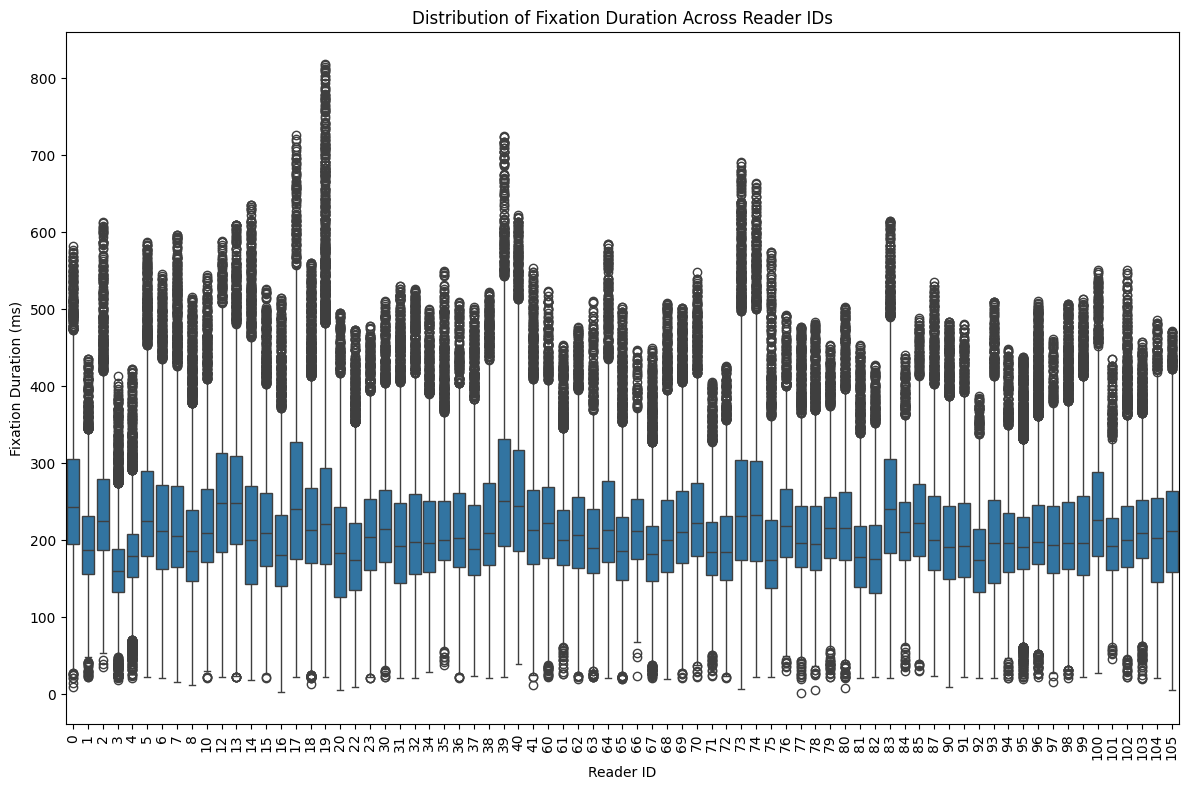

In [15]:
# Fixation duration distribution across participants
plt.figure(figsize=(12, 8))
sns.boxplot(x='reader_id', y='fixation_duration', data=scanpath_analysis_df)
plt.title('Distribution of Fixation Duration Across Reader IDs')
plt.xlabel('Reader ID')
plt.ylabel('Fixation Duration (ms)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Visual inspection of the plot shows that fixation durations are mainly distributed around **200–300 ms**, which is in line with typical reading behavior 
After cleaning the data using z-scores, the maximum fixation duration we observe is **~800 ms** (for reader ID 18).  

For further analyses, we will group participants according to their **expertise level** to investigate whether reading measures differ systematically between experts and non-experts.


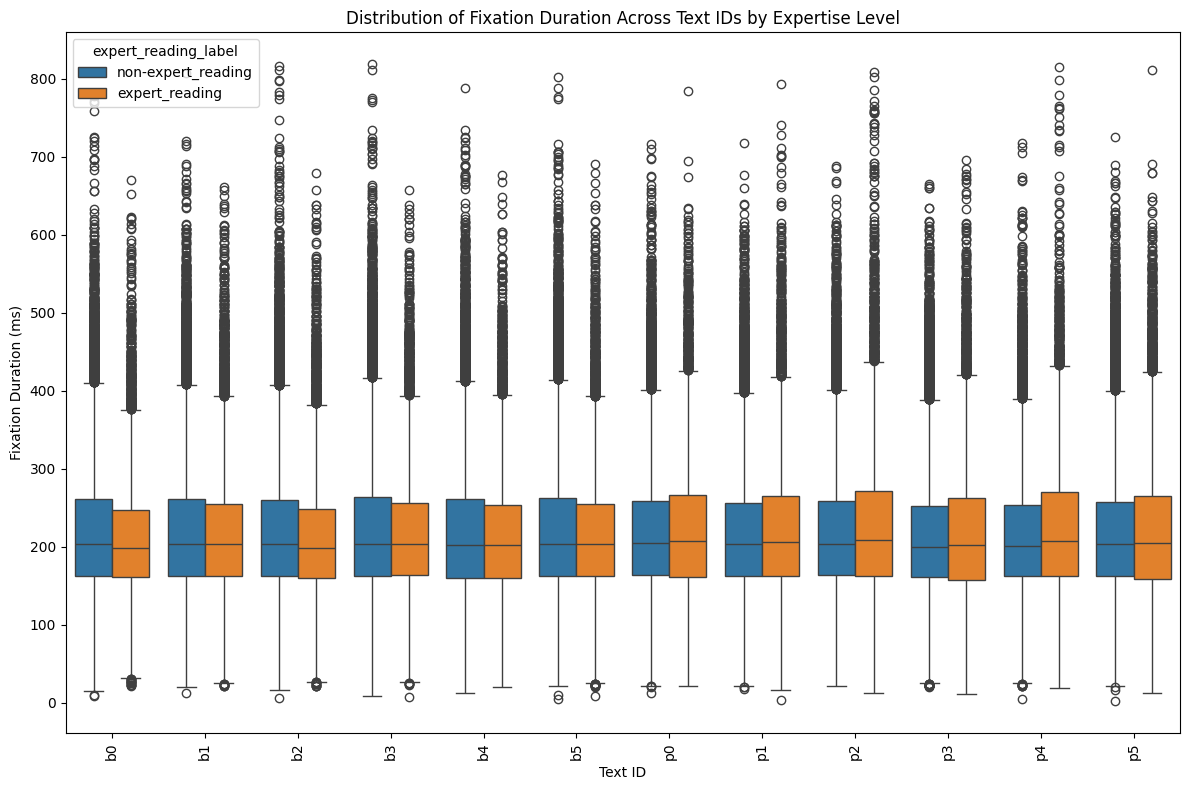

In [16]:
# fixation duration distribution for text_ids based on expertise level
plt.figure(figsize=(12, 8))
sns.boxplot(x='text_id', y='fixation_duration', hue='expert_reading_label', data=scanpath_analysis_df)
plt.title('Distribution of Fixation Duration Across Text IDs by Expertise Level')
plt.xlabel('Text ID')
plt.ylabel('Fixation Duration (ms)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# compute averaged fixation duration
avg_fixation_duration = scanpath_analysis_df.groupby(['text_id','expert_reading_label'])['fixation_duration'].mean().reset_index()
avg_fixation_duration.columns = ['text_id', 'expert_reading_label', 'mean_FD']
avg_fixation_duration.head()


,text_id,expert_reading_label,mean_FD
0,b0,expert_reading,210.142001
1,b0,non-expert_reading,217.308047
2,b1,expert_reading,215.386572
3,b1,non-expert_reading,217.138004
4,b2,expert_reading,209.665295


Since the average fixation times are consistently above **200 ms**, we limit the y-axis of our plots to start at **200 ms**.  
This makes it easier to observe potential differences in fixation duration between **experts** and **non-experts**, without being distracted by an unused lower range of the axis

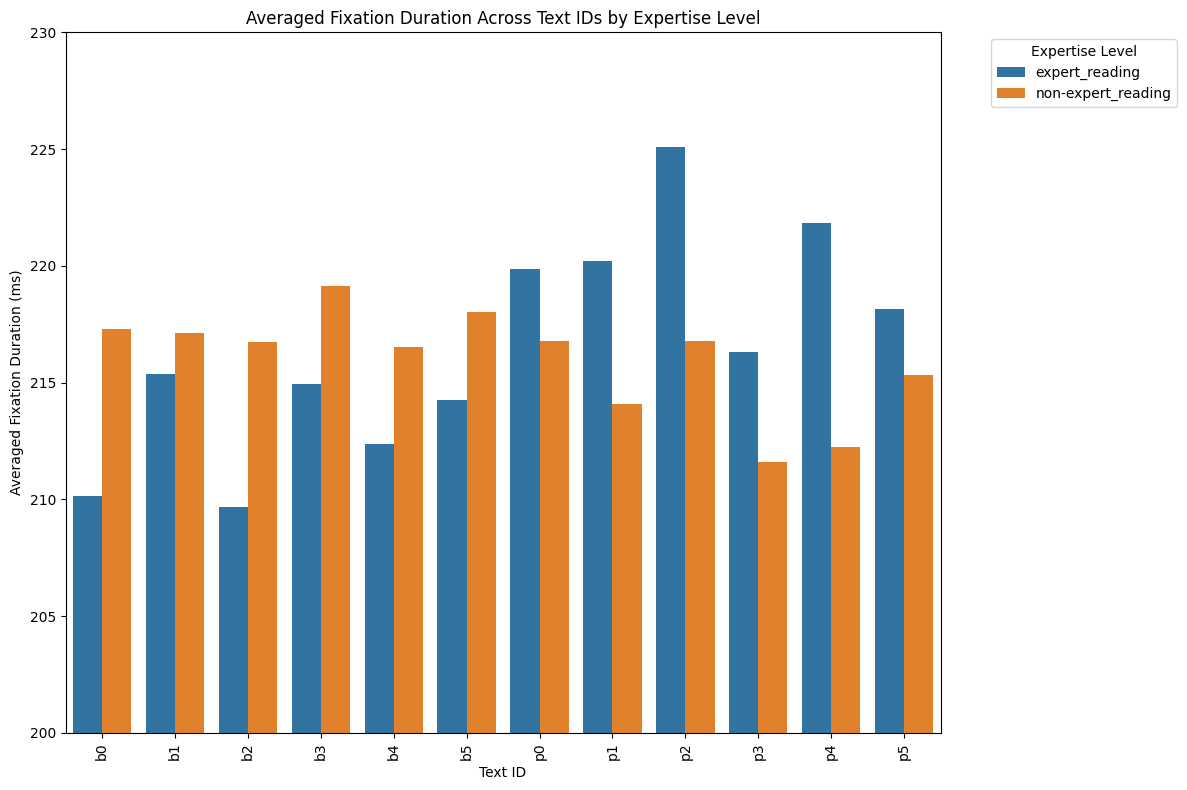

In [18]:
#plot averaged fixation duration with fixed y to see differences
plt.figure(figsize=(12, 8))
sns.barplot(x='text_id', y='mean_FD', hue='expert_reading_label', data=avg_fixation_duration)
plt.title('Averaged Fixation Duration Across Text IDs by Expertise Level')
plt.xlabel('Text ID')
plt.ylabel('Averaged Fixation Duration (ms)')
plt.ylim(200, 230)  # Set y-axis limit to better visualize differences
plt.xticks(rotation=90)
# Add legend outside of plot
plt.legend(title='Expertise Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From the current visualization, we observe that for **biology texts**, experts exhibit slightly **lower averaged fixation durations** compared to non-experts in the field.  
This pattern **does not appear for physics texts**.  

We will perform further sanity checks to verify and quantify this observation.


In [19]:
# check whether experts had longer fixation duration than non experts in p0 text_id using scanpath_analysis_df

expert_fixation = scanpath_analysis_df[(scanpath_analysis_df['expert_reading_label'] == 'expert_reading') & (scanpath_analysis_df['text_id'] == 'p0')]
non_expert_fixation = scanpath_analysis_df[(scanpath_analysis_df['expert_reading_label'] == 'non-expert_reading') & (scanpath_analysis_df['text_id'] == 'p0')]
print(f"Expert fixation duration for p0: {expert_fixation['fixation_duration'].values[0]:.2f} ms")
print(f"Non-expert fixation duration for p0: {non_expert_fixation['fixation_duration'].values[0]:.2f} ms")

Expert fixation duration for p0: 232.00 ms
Non-expert fixation duration for p0: 224.00 ms


In [20]:
# check whether experts had longer fixation duration than non experts in p1 text_id using scanpath_analysis_df

expert_fixation = scanpath_analysis_df[(scanpath_analysis_df['expert_reading_label'] == 'expert_reading') & (scanpath_analysis_df['text_id'] == 'p1')]
non_expert_fixation = scanpath_analysis_df[(scanpath_analysis_df['expert_reading_label'] == 'non-expert_reading') & (scanpath_analysis_df['text_id'] == 'p1')]
print(f"Expert fixation duration for p1: {expert_fixation['fixation_duration'].values[0]:.2f} ms")
print(f"Non-expert fixation duration for p1: {non_expert_fixation['fixation_duration'].values[0]:.2f} ms")

Expert fixation duration for p1: 289.00 ms
Non-expert fixation duration for p1: 197.00 ms


When comparing fixations of experts and non-experts on two physics texts(p0,p1), we observe that the earlier effect persists: **physics experts show longer fixation durations** than non-experts


### 2.3 Skipping Behavior
- Compute proportion of skipped words (`Fix == 0`)
- Compare skipping rates across groups and domains

We define **skipped words** as words that received **no fixation**, i.e., cases where the variable `Fix = 0`

In [21]:
# compute proportion of skipped words across readers and their expertise level
skipped_words_reader_expertise = (scanpath_analysis_df.groupby(['reader_id', 'expert_reading_label'])['Fix']
                 .apply(lambda x: (x == 0).mean())
                 .reset_index(name='proportion_skipped'))
skipped_words_reader_expertise.head()

,reader_id,expert_reading_label,proportion_skipped
0,0,expert_reading,0.000471
1,0,non-expert_reading,0.000000
2,1,expert_reading,0.000000
3,1,non-expert_reading,0.000422
4,2,expert_reading,0.001304


In [23]:
# skipped words across text
skipped_words_expert = (scanpath_analysis_df.groupby(['expert_reading_label'])['Fix']
                 .apply(lambda x: (x == 0).mean())
                 .reset_index(name='proportion_skipped'))
skipped_words_expert.head()

,expert_reading_label,proportion_skipped
0,expert_reading,0.000339
1,non-expert_reading,0.000227


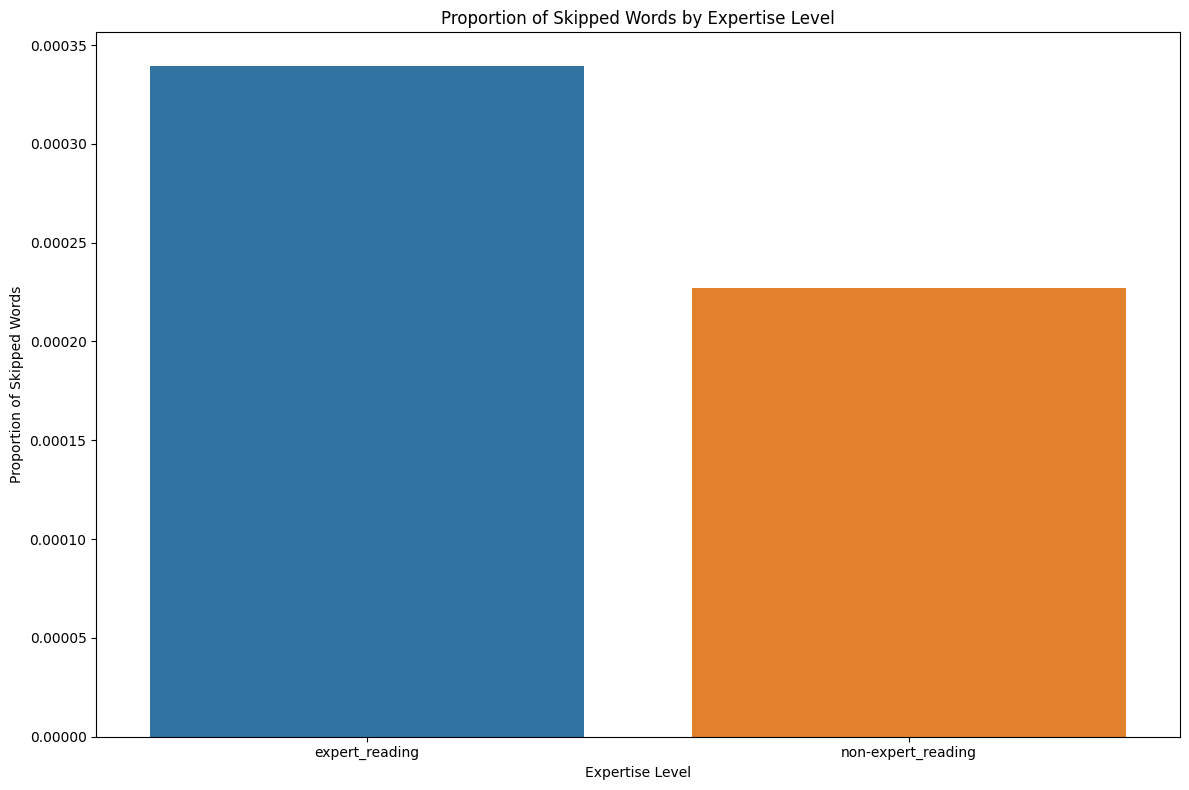

In [24]:
# plot skipped_words_expert
plt.figure(figsize=(12, 8))
sns.barplot(data=skipped_words_expert, x='expert_reading_label', y='proportion_skipped', hue='expert_reading_label')
plt.title('Proportion of Skipped Words by Expertise Level')
plt.xlabel('Expertise Level')
plt.ylabel('Proportion of Skipped Words')
plt.xticks()
plt.tight_layout()
plt.show()


From the visualizations so far, it appears that **experts tend to skip more words** while reading the texts.  

To investigate this pattern in more detail, we will plot the **proportion of skipped words across the 12 texts** to identify exactly where these differences occur between experts and non-experts.


In [25]:
# skipped words across text
skipped_words_text = (scanpath_analysis_df.groupby(['text_id', 'expert_reading_label'])['Fix']
                 .apply(lambda x: (x == 0).mean())
                 .reset_index(name='proportion_skipped'))
skipped_words_text.head()

,text_id,expert_reading_label,proportion_skipped
0,b0,expert_reading,0.000418
1,b0,non-expert_reading,0.000152
2,b1,expert_reading,0.000549
3,b1,non-expert_reading,0.000161
4,b2,expert_reading,0.000383


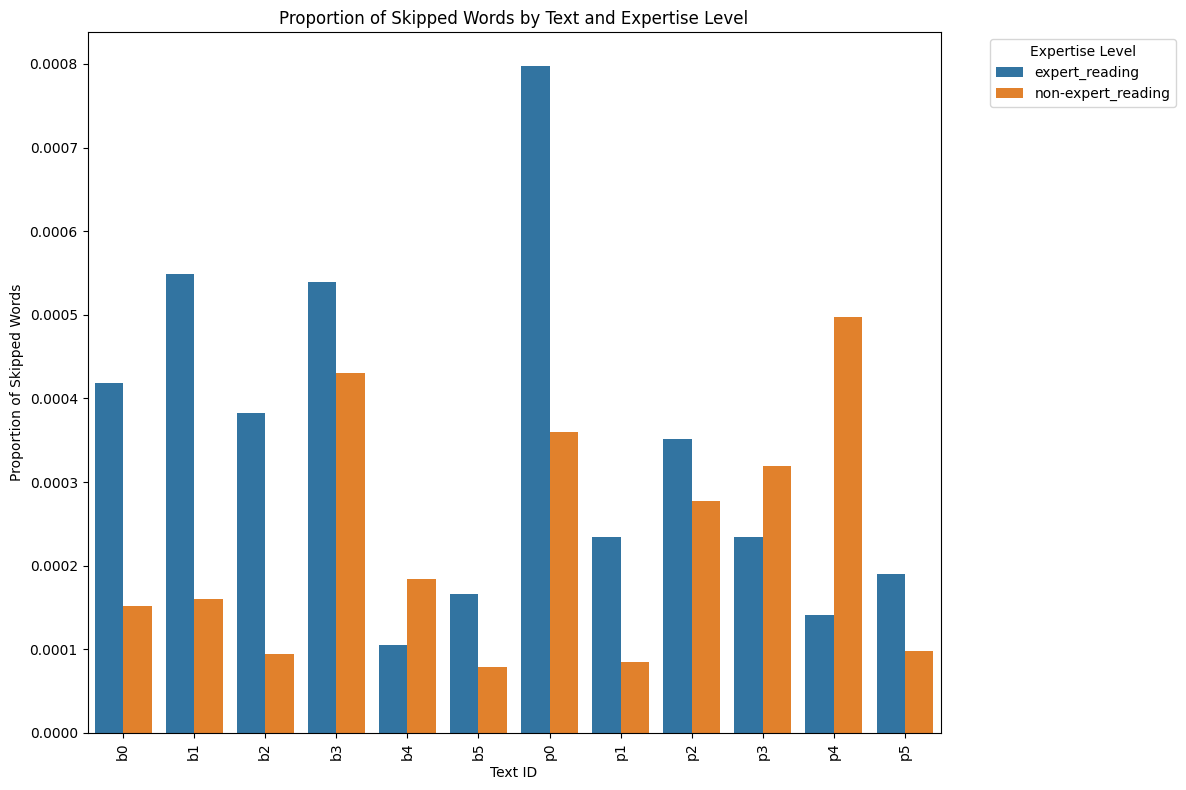

In [26]:
# plot proportion of skipped words across texts for expert reading label as barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=skipped_words_text, x='text_id', y='proportion_skipped', hue='expert_reading_label')
plt.title('Proportion of Skipped Words by Text and Expertise Level')
plt.xlabel('Text ID')
plt.ylabel('Proportion of Skipped Words')
plt.xticks(rotation=90)
# Add legend outside of plot
plt.legend(title='Expertise Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Examining the proportion of skipped words across the 12 texts, we observe the following patterns:

- **Biology texts (b0–b3,b5):** Experts consistently skip more words than non-experts.  
- **Some physics texts (p0, p1, p2, p5):** Experts also show a tendency to skip more words.  
- **Other biology and physics texts (b4, p3, p4):** Non-experts skip more words.  

The higher skipping rate for non-experts on certain physics and biology texts may indicate that these texts are particularly difficult for them, leading to disengagement and more skipped words.  
Overall, the general tendency to skip more words remains **more pronounced for experts**


### 2.4 Aggregated Measures per Participant
- Compute mean fixation measures per participant (FFD,RRT,FPRT, TFT)
- Visualize distributions
- Test for group differences

In [27]:
# compute mean first fix duration per reader
mean_ffd = scanpath_analysis_df.groupby('reader_id')['FFD'].mean().reset_index()
mean_ffd.columns = ['reader_id', 'mean_FFD']
mean_ffd.head()

,reader_id,mean_FFD
0,0,259.742315
1,1,154.388420
2,2,225.161000
3,3,160.799307
4,4,148.935493


In [28]:
# compute mean first pass reading time duration per reader
mean_fprt = scanpath_analysis_df.groupby('reader_id')['FPRT'].mean().reset_index()
mean_fprt.columns = ['reader_id', 'mean_FPRT']
mean_fprt.head()


,reader_id,mean_FPRT
0,0,518.206188
1,1,292.815364
2,2,511.088693
3,3,315.089446
4,4,244.716442


In [29]:
# compute mean re-reading time per reader
mean_rrt = scanpath_analysis_df.groupby('reader_id')['RRT'].mean().reset_index()
mean_rrt.columns = ['reader_id', 'mean_RRT']
mean_rrt.head()


,reader_id,mean_RRT
0,0,1030.992615
1,1,628.975610
2,2,763.128636
3,3,548.535452
4,4,518.159484


In [30]:
# compute mean total fixation time duration per reader
mean_tft = scanpath_analysis_df.groupby('reader_id')['TFT'].mean().reset_index()
mean_tft.columns = ['reader_id', 'mean_TFT']
mean_tft.head()

,reader_id,mean_TFT
0,0,1549.198802
1,1,921.790973
2,2,1274.217329
3,3,863.624898
4,4,762.875926


In [31]:
# merge mean fixation duration
mean_durations = mean_ffd.merge(mean_fprt, on='reader_id').merge(mean_tft, on='reader_id').merge(mean_rrt, on='reader_id')
mean_durations.head()

,reader_id,mean_FFD,mean_FPRT,mean_TFT,mean_RRT
0,0,259.742315,518.206188,1549.198802,1030.992615
1,1,154.388420,292.815364,921.790973,628.975610
2,2,225.161000,511.088693,1274.217329,763.128636
3,3,160.799307,315.089446,863.624898,548.535452
4,4,148.935493,244.716442,762.875926,518.159484


In [32]:
# Compute proportions of TFT (what percentage of each component contributes to the total fixation time)
mean_durations["FFD_prop"] = mean_durations["mean_FFD"] / mean_durations["mean_TFT"]
mean_durations["FPRT_prop"] = mean_durations["mean_FPRT"] / mean_durations["mean_TFT"]
mean_durations["RRT_prop"] = mean_durations["mean_RRT"] / mean_durations["mean_TFT"]

# Prepare data for stacked bar plot
props = mean_durations[["FFD_prop", "FPRT_prop", "RRT_prop"]]

In [33]:
mean_durations

,reader_id,mean_FFD,mean_FPRT,mean_TFT,mean_RRT,FFD_prop,FPRT_prop,RRT_prop
0,0,259.742315,518.206188,1549.198802,1030.992615,0.167662,0.334499,0.665501
1,1,154.388420,292.815364,921.790973,628.975610,0.167487,0.317659,0.682341
2,2,225.161000,511.088693,1274.217329,763.128636,0.176705,0.401100,0.598900
3,3,160.799307,315.089446,863.624898,548.535452,0.186191,0.364845,0.635155
4,4,148.935493,244.716442,762.875926,518.159484,0.195229,0.320781,0.679219
...,...,...,...,...,...,...,...,...
70,101,155.327173,282.155817,420.806804,138.650987,0.369118,0.670512,0.329488
71,102,208.503658,423.395270,1358.791220,935.395950,0.153448,0.311597,0.688403
72,103,195.530146,339.483103,1075.884217,736.401114,0.181739,0.315539,0.684461
73,104,186.900631,303.723834,848.579067,544.855233,0.220251,0.357920,0.642080


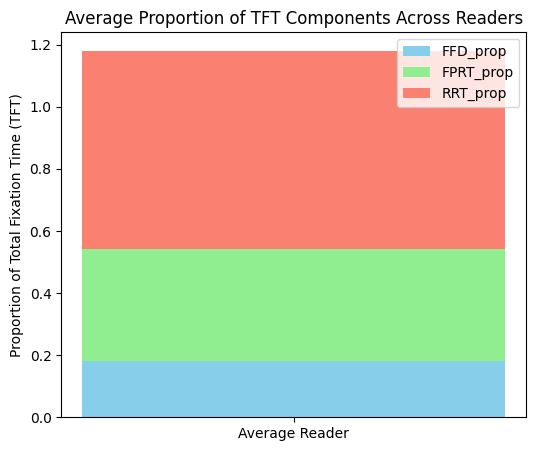

In [34]:
mean_props = mean_durations.mean()[["FFD_prop", "FPRT_prop", "RRT_prop"]]
fig, ax = plt.subplots(figsize=(6,5))

bottom = 0
colors = ["skyblue", "lightgreen", "salmon"]

for i, comp in enumerate(mean_props.index):
    ax.bar("Average Reader", mean_props[comp], bottom=bottom, color=colors[i], label=comp)
    bottom += mean_props[comp]

ax.set_ylabel("Proportion of Total Fixation Time (TFT)")
ax.set_title("Average Proportion of TFT Components Across Readers")
ax.legend()
plt.show()


The distribution of total fixation time (TFT) for average reader indicates the following pattern:

- On average, readers spend the **least time on first fixation duration (FFD)**, reflecting initial lexical processing.  
- They then spend **more time on first-pass reading (FPRT)**, scanning through the text.  
- Finally, they spend the **most time on re-reading (RRT)**, likely to integrate or clarify information during a second pass.  

This pattern aligns with typical reading behavior, where initial fixations capture word recognition, followed by first-pass reading, and then selective re-reading for comprehension.


For further investigation we can look up for distribution across individual readers

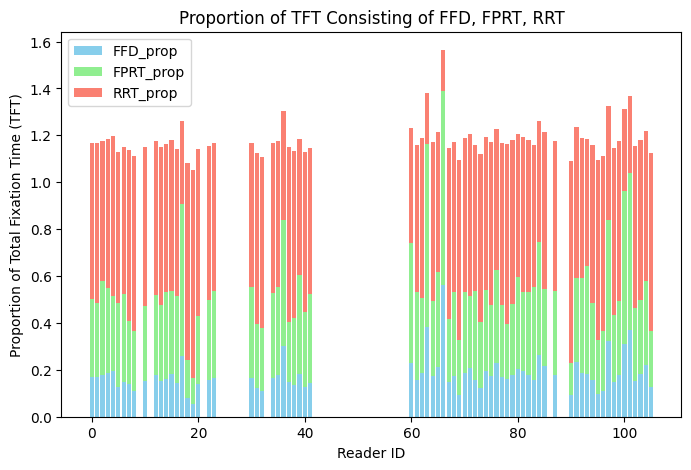

In [35]:
# Plot proportion of TFT components
fig, ax = plt.subplots(figsize=(8,5))

bottom = None
colors = ["skyblue", "lightgreen", "salmon"]

for i, col in enumerate(props.columns):
    if bottom is None:
        ax.bar(mean_durations["reader_id"], props[col], color=colors[i], label=col)
        bottom = props[col]
    else:
        ax.bar(mean_durations["reader_id"], props[col], bottom=bottom, color=colors[i], label=col)
        bottom += props[col]

ax.set_xlabel("Reader ID")
ax.set_ylabel("Proportion of Total Fixation Time (TFT)")
ax.set_title("Proportion of TFT Consisting of FFD, FPRT, RRT")
ax.legend()
plt.show()

Plotting the average proportions of TFT components across individual readers also reveals the same pattern, with FFD being the smallest proportion, followed by FPRT, and RRT being the largest proportion for most readers. However, there is some variability among individual readers in the exact proportions of each component.

further we want to investigate whether there are differences in TFT between experts and non-experts

In [36]:
# Participant-level TFT averages
participant_tft = scanpath_analysis_df.groupby(['reader_id', 'expert_reading_label'])['TFT'].mean().reset_index()
participant_tft.head()

,reader_id,expert_reading_label,TFT
0,0,expert_reading,1351.497407
1,0,non-expert_reading,1694.344064
2,1,expert_reading,743.946535
3,1,non-expert_reading,1073.563583
4,2,expert_reading,1155.501956


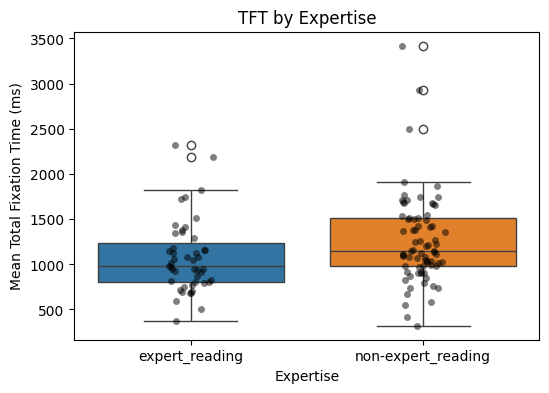

In [37]:
# Plot tft across readers
plt.figure(figsize=(6,4))
sns.boxplot(data=participant_tft, x='expert_reading_label', y='TFT',hue='expert_reading_label')
sns.stripplot(data=participant_tft, x='expert_reading_label', y='TFT', color='black', alpha=0.5)
plt.ylabel("Mean Total Fixation Time (ms)")
plt.xlabel("Expertise")
plt.title("TFT by Expertise")
plt.show()


Visual inspection of the data shows that **experts spend less time on average for total fixation time (TFT)** compared to non-expert readers.  

To formally assess whether this difference is statistically significant, we will perform an **independent t-test** between the two groups.


In [38]:
# running t-test
experts = participant_tft[participant_tft['expert_reading_label']=='expert_reading']['TFT']
non_experts = participant_tft[participant_tft['expert_reading_label']=='non-expert_reading']['TFT']

t_stat, p_val = ttest_ind(experts, non_experts, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")


T-statistic: -2.222, p-value: 0.028


The independent t-test comparing total fixation time (TFT) between experts and non-experts yielded:

- **T-statistic:** -2.222  
- **p-value:** 0.028  

Since the p-value is below the conventional threshold of 0.05, this difference is **statistically significant**.  
The negative T-statistic indicates that **experts spend less time on total fixations** compared to non-experts, consistent with more efficient reading behavior.

### 2.5 Effects of Word Properties

We investigate how **word-level properties** influence fixation behavior, and whether this effect differs by expertise.

- **Fixation duration vs. word length:** Do participants fixate longer on longer words?  


To examine the effect of word length on FFD, we **binned words into length categories** (e.g., 2–7, 8–12, 13–17, etc.).  
This helps to **smooth the visualization** and make the trends more interpretable.  

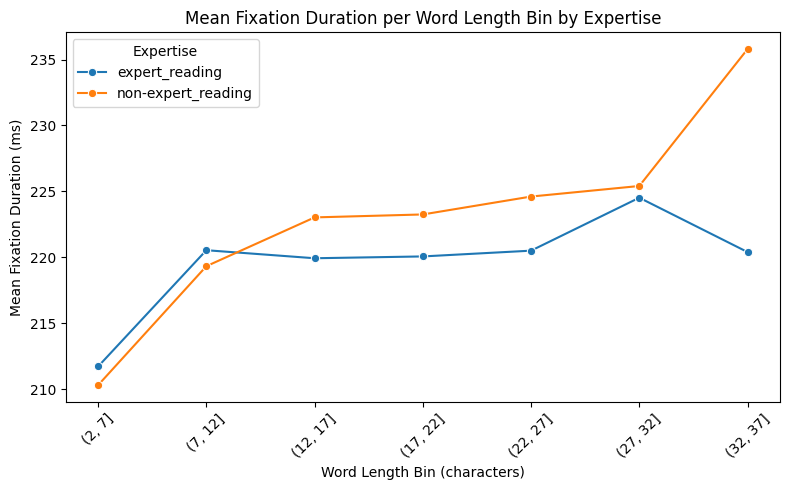

In [73]:
# Create word length bins (e.g., 1–5, 6–10, 11–15, etc.)
bin_edges = np.arange(scanpath_analysis_df['word_length'].min(), scanpath_analysis_df['word_length'].max() + 6, 5)
scanpath_analysis_df['word_length_bin'] = pd.cut(scanpath_analysis_df['word_length'], bins=bin_edges)

# Compute mean FFD per bin and expertise
mean_ffd = scanpath_analysis_df.groupby(['expert_reading_label', 'word_length_bin'], observed=True)['fixation_duration'].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(
    data=mean_ffd,
    x=mean_ffd['word_length_bin'].astype(str),
    y='fixation_duration',
    hue='expert_reading_label',
    marker='o'
)

plt.xticks(rotation=45)
plt.xlabel("Word Length Bin (characters)")
plt.ylabel("Mean Fixation Duration (ms)")
plt.title("Mean Fixation Duration per Word Length Bin by Expertise")
plt.legend(title="Expertise")
plt.tight_layout()
plt.show()


- For **non-experts**, mean FFD **increases steadily with word length**, indicating that longer words require more processing time.  
- For **experts**, mean FFD shows a **positive correlation for shorter words (length 2–12)**, but becomes **more stable for longer words**, suggesting that experts are **less affected by variations in word length**.


We fit a **linear mixed-effects model** to examine the influence of **word length** and **expertise level** on fixation duration.  
The model specification was:  

`fixation_duration ~ word_length * expert_reading_label * (1|reader_id)"`
- **Fixed effects:**  
  - Main effects of `word_length` and `expertise_level`  
  - Interaction between `word_length` and `expertise_level`  
- **Random effects:**  
  - A random intercept for each `reader_id`, to account for individual variability in overall fixation durations.  

This model tests whether the **relationship between word length and fixation duration** differs for experts and non-experts, while controlling for differences between readers.


In [75]:
# Fit mixed model with interaction
model = smf.mixedlm(
    "fixation_duration ~ word_length * expert_reading_label * (1|reader_id)",
    data=scanpath_analysis_df,
    groups=scanpath_analysis_df["reader_id"]
)
result = model.fit()


In [76]:
# predict fd with mixed lm
scanpath_analysis_df['predicted_fd'] = result.predict(scanpath_analysis_df)

In [77]:
mean_ffd_predicted = scanpath_analysis_df.groupby(['expert_reading_label', 'word_length_bin'], observed=True)['predicted_fd'].mean().reset_index()

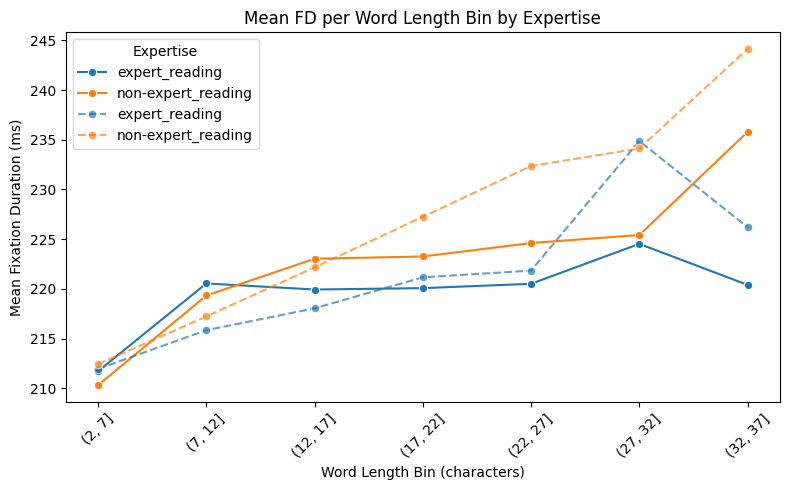

In [78]:
# Plot mean ffd and mean predicted
plt.figure(figsize=(8,5))
sns.lineplot(
    data=mean_ffd,
    x=mean_ffd['word_length_bin'].astype(str),
    y='fixation_duration',
    hue='expert_reading_label',
    marker='o'
)
sns.lineplot(
    data=mean_ffd_predicted,
    x=mean_ffd_predicted['word_length_bin'].astype(str),
    y='predicted_fd',
    hue='expert_reading_label',
    marker='o',
    linestyle='--',
    alpha=0.7
)

plt.xticks(rotation=45)
plt.xlabel("Word Length Bin (characters)")
plt.ylabel("Mean Fixation Duration (ms)")
plt.title("Mean FD per Word Length Bin by Expertise")
plt.legend(title="Expertise")
plt.tight_layout()
plt.show()


The mixed-effects model tends to predict somewhat longer fixation durations overall, but it successfully captures the key trends observed in the data:  

- **Non-experts** show consistently higher fixation durations compared to experts.  
- **Experts** generally exhibit lower fixation durations, reflecting more efficient reading.  
- The model also depicts a noticeable **increase in fixation duration for very long words (27–32 characters)** among experts, suggesting that even highly skilled readers slow down when processing unusually long words.


### 2.6 Scanpath Previews
- Plot scanpaths (sequence of fixations across words/lines) for a few participants

In [49]:
def plot_scanpath(data, reader_id, text_id):
    # Filter for one reader and one text
    df = data[(data['reader_id'] == int(reader_id)) & (data['text_id'] == text_id)].copy()
    #print(df)
    df = df.sort_values(by='fixation_index')  # Ensure sequential order

    plt.figure(figsize=(10, 6))
    
    # Plot fixations as circles
    plt.scatter(
        df['word_index_in_text'], df['line'],
        s=df['fixation_duration'] / 5,  # scale size by duration
        c='blue', alpha=0.6, edgecolors='k'
    )
    
    # Plot saccades as lines between fixations
    plt.plot(df['word_index_in_text'], df['line'], c='gray', alpha=0.5)
    
    plt.gca().invert_yaxis()  # so line numbers go top-down like reading
    plt.xlabel("Word Index in Text")
    plt.ylabel("Line Number")
    plt.title(f"Scanpath for Reader {reader_id}, Text {text_id}")
    plt.show()



In [50]:
columns_scanpath=['reader_id', 'text_id', 'word_index_in_text', 'line', 'fixation_duration', 'fixation_index']
scanpath_plot_df = scanpath_df[columns_scanpath]

In [51]:
scanpath_plot_df.head()

,reader_id,text_id,word_index_in_text,line,fixation_duration,fixation_index
0,0,b0,2,1,281,1
1,0,b0,3,1,283,2
2,0,b0,5,1,394,3
3,0,b0,5,1,254,4
4,0,b0,5,1,340,5


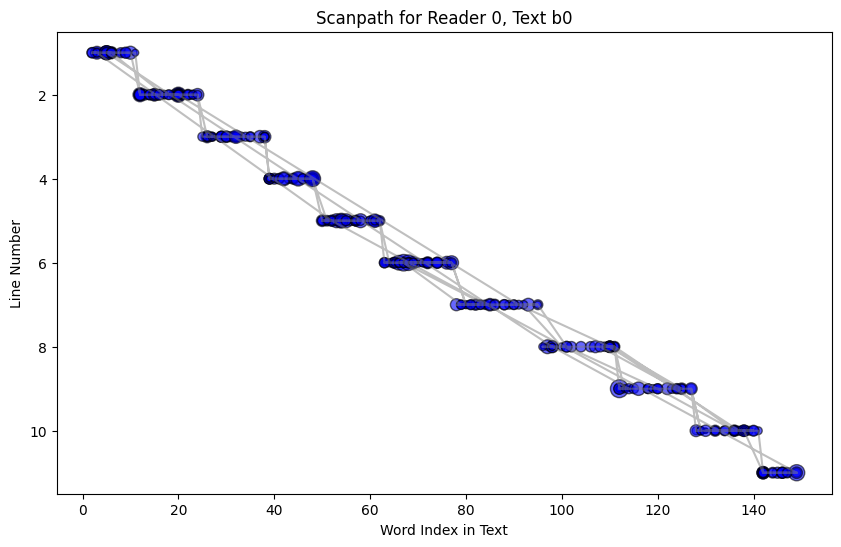

In [52]:
plot_scanpath(scanpath_plot_df, reader_id=0, text_id='b0')

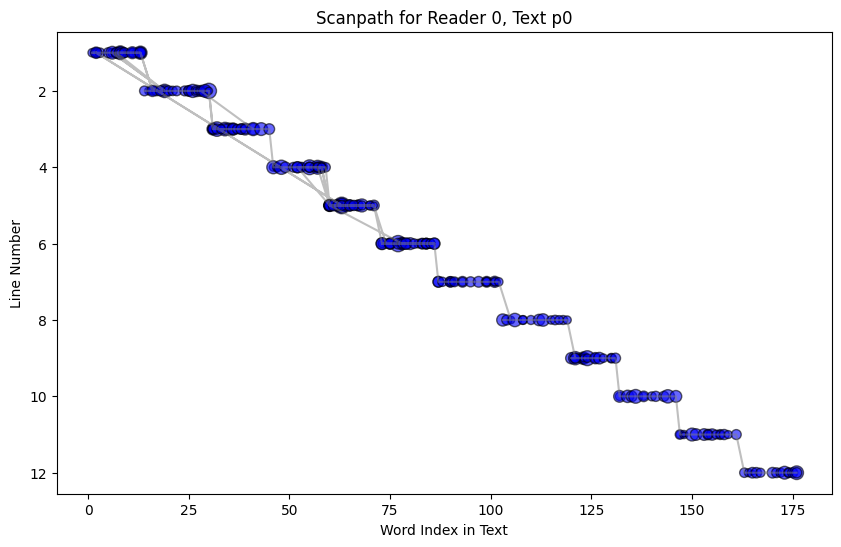

In [53]:
plot_scanpath(scanpath_plot_df, reader_id=0, text_id='p0')